
# Semi-Supervised ML
In the semi-supervised setting, a large unlabeled dataset and a small labeled dataset are given. The goal is to train a classifier on the entire dataset that would predict the labels of the unlabeled data points in the training set. This is called transductive semi-supervised learning. In the present problem, we have created a semi-supervised learning dataset consisting of $92\%$  unlabeled data points and $8\%$ labeled data points.

Using self-training semi-supervised learning method, we trained three base classifiers:

1. Logistic Regression 

2. Random Forest 

3. XGBoost

We use the ground truth (true lables) of the unlabeled dataset to validate the performance of the self-training semi-supervised learning models, but in reality the ground truth of the unlabeled data points will not be provided.

In [1]:
%matplotlib inline

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set font scale and style
plt.rcParams.update({'font.size': 15})

# Machine learning models
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier

# Pickle
import joblib

In [2]:
# Import custom class
%run -i '../src/helper/ss_transfxns.py'
%run -i '../src/helper/ss_ml.py'
%run -i '../src/helper/sup_ml.py'

In [3]:
# Instantiate the class
transfxn = TransformationPipeline()
model = SemiSupervised()

# Load data

In [4]:
df = pd.read_csv('../data/kdd99-unsupervised-ad.csv', header = None)
print("Data size:", df.shape) # print data size
df.columns = ['v_{}'.format(i) for i in range(30)] # column names
df = (df.sample(frac =1)).reset_index(drop = True) # Shuffle the data
df.head() # display the data

Data size: (620098, 30)


,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,...,v_20,v_21,v_22,v_23,v_24,v_25,v_26,v_27,v_28,v_29
0,0.0,212.0,888.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,101.0,1.0,0.0,0.01,0.02,0.00,0.00,0.0,0.0,n
1,0.0,236.0,5381.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,255.0,1.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,n
2,0.0,241.0,28526.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,89.0,1.0,0.0,0.07,0.09,0.07,0.01,0.0,0.0,n
3,0.0,241.0,13291.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,255.0,1.0,0.0,0.07,0.04,0.00,0.00,0.0,0.0,n
4,0.0,212.0,1157.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,255.0,1.0,0.0,0.50,0.04,0.00,0.00,0.0,0.0,n


# Categorical variables encoded as integers

In [5]:
# Convert to string
cols = ['v_6', 'v_7', 'v_8', 'v_9']
for i, val in enumerate(cols):
    df[val] = df[val].astype('O')

# Create feature matrix and class label

In [6]:
X, y = df.drop('v_29', axis = 1), df.v_29

# Create unlabeled dataset
In this section, we remove some labels and relabel them as unknown, which is indicated by -1

In [7]:
# Map to binary
y_ = y.map({'n':0, 'o':1})

In [8]:
n_total_samples = len(y_)
n_labeled_points = 50000

#####################################################
indices = np.arange(n_total_samples)
unlabeled_set = indices[n_labeled_points:]

#####################################################
y_train = np.copy(y_)
y_train[unlabeled_set] = -1 # set unlabeled dataset to -1
y_true = y_[unlabeled_set] # True labels of the unlabeled dataset

In [9]:
print("Original class distribution")
label_pct = y_.map({0:'normal',1: 'attack'}).value_counts()*100/len(y_)
label_ct =  y_.map({0:'normal',1: 'attack'}).value_counts()
pd.DataFrame({'labels': label_pct.index, 'count': label_ct.values, 
                'percentage': label_pct.values
                })

Original class distribution


,labels,count,percentage
0,normal,619046,99.830349
1,attack,1052,0.169651


In [10]:
print("Class distribution for semi-supervised learning")
label_pct = pd.Series(y_train).map({0:'normal',1: 'attack', -1: 'unknown'}).value_counts(normalize=True)*100
label_ct =  pd.Series(y_train).map({0:'normal',1: 'attack', -1: 'unknown'}).value_counts()
pd.DataFrame({'labels': label_pct.index, 'count': label_ct.values,
              'percentage': label_pct.values
              })

Class distribution for semi-supervised learning


,labels,count,percentage
0,unknown,570098,91.936758
1,normal,49908,8.048405
2,attack,92,0.014836


In [11]:
print(" Class distribution for true labels of the unlabeled dataset")
label_pct = y_true.map({0:'normal',1: 'attack'}).value_counts()*100/len(y_true)
label_ct =  y_true.value_counts()
pd.DataFrame({'labels': label_pct.index, 'count': label_ct.values,
              'percentage': label_pct.values
              })

 Class distribution for true labels of the unlabeled dataset


,labels,count,percentage
0,normal,569138,99.831608
1,attack,960,0.168392


# Transformation pipeline

In [12]:
# Transform and scale data
X_train_scaled, feat_nm = transfxn.preprocessing(X)

In [13]:
print('Training set size after pre-processing:', X_train_scaled.shape, y_train.shape)

Training set size after pre-processing: (620098, 33) (620098,)


#  Self-Training Semi-Supervised Learning

# A-1. Logistic Regression

In [15]:
lr_base_classifier = LogisticRegression(random_state = 42)
lr_y_pred, y_proba = model.self_training_clf(lr_base_classifier, X_train_scaled, y_train,
                                          threshold= 0.75, max_iter = None,verbose = True)

print('-' * 40)
print("Predicted labels for {} unlabeled data points:".format(len(y_true)))
pd.Series(lr_y_pred[unlabeled_set]).value_counts()

End of iteration 1, added 570087 new labels.
End of iteration 2, added 3 new labels.
End of iteration 3, added 2 new labels.
----------------------------------------
Predicted labels for 570098 unlabeled data points:


0    569140
1       958
dtype: int64

# A-1-1. Performance metrics

We use the ground truth of the unlabeled dataset to validate the performance of the model, but in reality the ground truth of the unlabeled data points will not be provided

In [16]:
model.eval_metrics(y_true.values, lr_y_pred[unlabeled_set], 
                        model_nm = 'Logistic Regression')

Test predictions for Logistic Regression
------------------------------------------------------------
Accuracy:  0.999925
AUROC: 0.985085
AUPRC: 0.956068
Predicted classes: [0 1]
Confusion matrix:
 [[569111     14]
 [    29    944]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    569125
           1       0.99      0.97      0.98       973

    accuracy                           1.00    570098
   macro avg       0.99      0.99      0.99    570098
weighted avg       1.00      1.00      1.00    570098

------------------------------------------------------------


# A-1-2. PCA plot

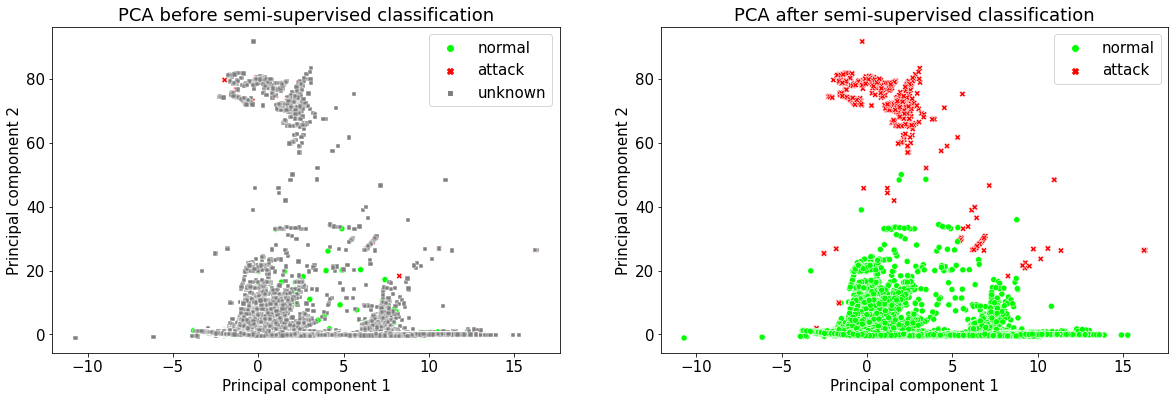

In [17]:
# Re-encode the class variable
y_train_ = pd.Series(y_train).map({0:'normal',1: 'attack', -1: 'unknown'})
lr_y_pred = pd.Series(lr_y_pred).map({0:'normal',1: 'attack'})

transfxn.plot_pca(X_train_scaled, y_train_, lr_y_pred)

# A-2. Random Forest

In [18]:
param_dist = {'n_estimators':100, 'random_state':42}
rf_base_classifier = RandomForestClassifier(**param_dist)
rf_y_pred, y_proba = model.self_training_clf(rf_base_classifier, X_train_scaled, y_train,
                                          threshold= 0.75, max_iter = None,verbose = True)

print('-' * 40)
print("Predicted labels for {} unlabeled data points:".format(len(y_true)))
pd.Series(rf_y_pred[unlabeled_set]).value_counts()

End of iteration 1, added 569978 new labels.
End of iteration 2, added 30 new labels.
End of iteration 3, added 4 new labels.
End of iteration 4, added 6 new labels.
End of iteration 5, added 14 new labels.
End of iteration 6, added 19 new labels.
End of iteration 7, added 8 new labels.
End of iteration 8, added 4 new labels.
End of iteration 9, added 5 new labels.
End of iteration 10, added 2 new labels.
End of iteration 11, added 2 new labels.
----------------------------------------
Predicted labels for 570098 unlabeled data points:


0    569161
1       937
dtype: int64

# A-2-1. Performance metrics
We use the ground truth of the unlabeled dataset to validate the performance of the model, but in reality the ground truth of the unlabeled data points will not be provided

In [19]:
model.eval_metrics(y_true.values, rf_y_pred[unlabeled_set],
                     model_nm = 'Random Forest Classifier')

Test predictions for Random Forest Classifier
------------------------------------------------------------
Accuracy:  0.999933
AUROC: 0.980986
AUPRC: 0.961012
Predicted classes: [0 1]
Confusion matrix:
 [[569124      1]
 [    37    936]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    569125
           1       1.00      0.96      0.98       973

    accuracy                           1.00    570098
   macro avg       1.00      0.98      0.99    570098
weighted avg       1.00      1.00      1.00    570098

------------------------------------------------------------


# A-2-2. PCA plot

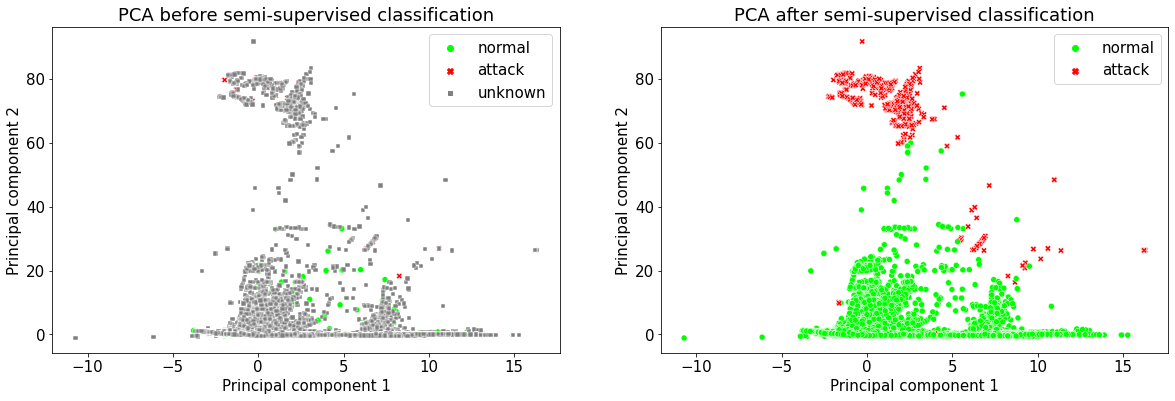

In [20]:
# Re-encode the class variable
y_train_ = pd.Series(y_train).map({0:'normal',1: 'attack', -1: 'unknown'})
rf_y_pred = pd.Series(rf_y_pred).map({0:'normal',1: 'attack'})

transfxn.plot_pca(X_train_scaled, y_train_, rf_y_pred)

# A-3 XGBoost

In [24]:
param_dist = {'objective':'binary:logistic', 'eval_metric':'logloss', 'n_estimators':1000, 
                'learning_rate':0.05, 'random_state':42
                }
                
xgb_base_classifier = XGBClassifier(**param_dist)
xgb_y_pred, y_proba = model.self_training_clf(xgb_base_classifier, X_train_scaled, y_train,
                                          threshold= 0.75, max_iter = None,verbose = True)
print('-' * 40)
print("Predicted labels for {} unlabeled data points:".format(len(y_true)))
pd.Series(xgb_y_pred[unlabeled_set]).value_counts()

End of iteration 1, added 570088 new labels.
End of iteration 2, added 10 new labels.
----------------------------------------
Predicted labels for 570098 unlabeled data points:


0    569165
1       933
dtype: int64

# A-3-1. Performance metrics
We use the ground truth of the unlabeled dataset to validate the performance of the model, but in reality the ground truth of the unlabeled data points will not be provided

In [25]:
model.eval_metrics(y_true.values, xgb_y_pred[unlabeled_set],
                     model_nm = 'XGBoost Classifier')

Test predictions for XGBoost Classifier
------------------------------------------------------------
Accuracy:  0.999926
AUROC: 0.978930
AUPRC: 0.956908
Predicted classes: [0 1]
Confusion matrix:
 [[569124      1]
 [    41    932]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    569125
           1       1.00      0.96      0.98       973

    accuracy                           1.00    570098
   macro avg       1.00      0.98      0.99    570098
weighted avg       1.00      1.00      1.00    570098

------------------------------------------------------------


# A-3-2. PCA plot

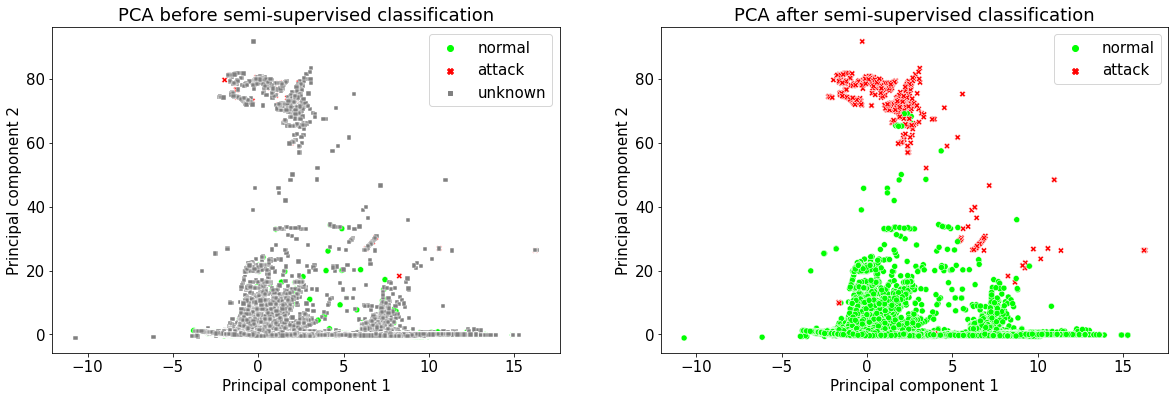

In [26]:
# Re-encode the class variable
y_train_ = pd.Series(y_train).map({0:'normal',1: 'attack', -1: 'unknown'})
xgb_y_pred = pd.Series(xgb_y_pred).map({0:'normal',1: 'attack'})

transfxn.plot_pca(X_train_scaled, y_train_, xgb_y_pred)

# Graph-Based Semi-Supervised Learning

# A-1. Label Spreading

In [ ]:
ls_y_pred, y_proba = model.label_spread(X_train_scaled, y_train, gamma = 20, max_iter = 30)

print('-' * 40)
print("Predicted labels for {} unlabeled data points:".format(len(y_true)))
pd.Series(ls_y_pred[unlabeled_set]).value_counts()

# A-1-1. Performance metrics
We use the ground truth of the unlabeled dataset to validate the performance of the model, but in reality the ground truth of the unlabeled data points will not be provided

In [ ]:
model.eval_metrics(y_true.values, ls_y_pred[unlabeled_set], model_nm = 'Label Spreading')

# A-1-2. PCA plot

In [ ]:
# Re-encode the class variable
y_train_ = pd.Series(y_train).map({0:'normal',1: 'attack', -1: 'unknown'})
xgb_y_pred = pd.Series(ls_y_pred).map({0:'normal',1: 'attack'})

transfxn.plot_pca(X_train_scaled, y_train_, ls_y_pred)